<a href="https://colab.research.google.com/github/Ankityadav98/Twitter-Sentiment-Analysis-Competition-by-Analytics-Vidhya/blob/master/GloVe_LSTM_AV_86_percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd '/content/gdrive/My Drive/ML/Sentiment analysis dataset'

/content/gdrive/My Drive/ML/Sentiment analysis dataset


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [5]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [6]:
train['label'].value_counts()

0    5894
1    2026
Name: label, dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7920 non-null   int64 
 1   label   7920 non-null   int64 
 2   tweet   7920 non-null   object
dtypes: int64(2), object(1)
memory usage: 185.8+ KB


In [8]:
df= pd.concat([train,test],axis=0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9873 entries, 0 to 1952
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      9873 non-null   int64  
 1   label   7920 non-null   float64
 2   tweet   9873 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 308.5+ KB


In [10]:
#!pip install -U spacy

In [11]:
#!python -m spacy download en

In [12]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string
import re
import spacy
sp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
def clean_data(text):
  #remove emails
  text = ' '.join([i for i in text.split() if '@' not in i])
    
  #remove web address
  text = re.sub('http[s]?://\S+', '', text)
    
  #Filter to allow only alphabets
  text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
  #Remove Unicode characters
  text = re.sub(r'[^\x00-\x7F]+', '', text)
    
  #Convert to lowercase to maintain consistency
  text = text.lower()
    
  #Remove stopwords
  all_stopwords = sp.Defaults.stop_words
  text_tokens = word_tokenize(text)
  tokens_without_sw= [word for word in text_tokens if not word in all_stopwords]
  text=' '.join(tokens_without_sw)
  
  #remove double spaces 
  text = re.sub('\s+', ' ',text)
  return (text)

In [14]:
df['clean_tweet']= df['tweet'].apply(clean_data)

In [15]:
df.tail()

,id,label,tweet,clean_tweet
1948,9869,NaN,"#SamsungGalaxyNote7 Explodes, Burns 6-Year-Old...",samsunggalaxynote explodes burns year old than...
1949,9870,NaN,Now Available - Hoodie. Check it out here - ht...,available hoodie check iphone case music discount
1950,9871,NaN,There goes a crack right across the screen. If...,goes crack right screen actually provide durab...
1951,9872,NaN,@codeofinterest as i said #Adobe big time we m...,said adobe big time include apple
1952,9873,NaN,Finally I got it .. thanx my father .. #Samsun...,finally got thanx father samsung galaxy s gift...


In [16]:
train_new= df[:7920].copy()
test_new= df[7920:].copy()

In [17]:
train_new.drop(columns=['id','tweet'],inplace=True)
train_new['label']=train_new['label'].astype(int)
train_new.head()

,label,clean_tweet
0,0,fingerprint pregnancy test android apps beauti...
1,0,finally transparant silicon case thanks uncle ...
2,0,love talk makememories unplug relax iphone sma...
3,0,wired know george way iphone cute daventry home
4,1,amazing service apple wo talk question pay stu...


In [18]:
test_new.drop(columns=['label','tweet'],inplace=True)
test_new.head()

,id,clean_tweet
0,7921,hate new iphone upgrade wo let download apps u...
1,7922,currently shitting fucking pants apple imac ca...
2,7923,like puts cd roms ipad possible ' yes block sc...
3,7924,ipod officially dead lost pictures videos d so...
4,7925,fighting itunes night want music paid


In [19]:
train_new= train_new.reindex(np.random.permutation(train_new.index))
train_new= train_new.reset_index(drop=True)

In [20]:
corpus=[]
labels=[]
for i in range(len(train_new)):
  corpus.append(train_new['clean_tweet'][i])
  labels.append(train_new['label'][i])

In [21]:
test_portion=0.2
split=int(test_portion*len(train_new))

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

In [23]:
oov_token='<OOV>'
pad_type='post'
trunc_type='post'
embedding_dim=100
max_length= 120 #max([len(x) for x in corpus])

In [24]:
tokenizer= Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(corpus)
word_index= tokenizer.word_index
vocab_size= len(word_index)
print(vocab_size)

sequences= tokenizer.texts_to_sequences(corpus)
padded= pad_sequences(sequences,maxlen=max_length,padding=pad_type,truncating=trunc_type)

val_sequences = padded[0:split]
train_sequences = padded[split:]
val_labels = labels[0:split]
train_labels = labels[split:]

16487


In [25]:
embeddings_index = {};
with open('/content/gdrive/My Drive/ML/GloVe/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [26]:
model = Sequential()
model.add(Embedding(vocab_size+1,embedding_dim,input_length=max_length,weights=[embeddings_matrix], trainable=False))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(16)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          1648800   
_________________________________________________________________
dropout (Dropout)            (None, 120, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                14976     
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,664,321
Trainable params: 15,521
Non-trainable params: 1,648,800
_________________________________________________________________


In [27]:
num_epochs = 20
training_padded= np.array(train_sequences)
training_labels= np.array(train_labels)
val_padded=  np.array(val_sequences)
val_labels= np.array(val_labels)

In [28]:
history = model.fit(training_padded,training_labels, epochs=num_epochs, validation_data=(val_padded,val_labels), verbose=1)

Epoch 1/20
198/198 [==============================] - 12s 59ms/step - loss: 0.4641 - accuracy: 0.7771 - val_loss: 0.3048 - val_accuracy: 0.8655
Epoch 2/20
198/198 [==============================] - 11s 55ms/step - loss: 0.3264 - accuracy: 0.8537 - val_loss: 0.2876 - val_accuracy: 0.8712
Epoch 3/20
198/198 [==============================] - 11s 55ms/step - loss: 0.3061 - accuracy: 0.8641 - val_loss: 0.2790 - val_accuracy: 0.8750
Epoch 4/20
198/198 [==============================] - 11s 55ms/step - loss: 0.2955 - accuracy: 0.8709 - val_loss: 0.2770 - val_accuracy: 0.8769
Epoch 5/20
198/198 [==============================] - 11s 55ms/step - loss: 0.2844 - accuracy: 0.8774 - val_loss: 0.2740 - val_accuracy: 0.8769
Epoch 6/20
198/198 [==============================] - 11s 55ms/step - loss: 0.2823 - accuracy: 0.8747 - val_loss: 0.2658 - val_accuracy: 0.8750
Epoch 7/20
198/198 [==============================] - 11s 55ms/step - loss: 0.2733 - accuracy: 0.8764 - val_loss: 0.2656 - val_accuracy:

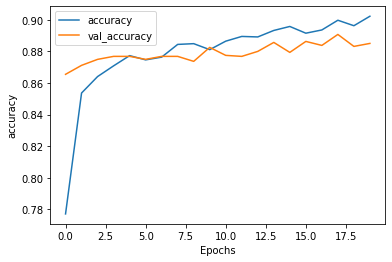

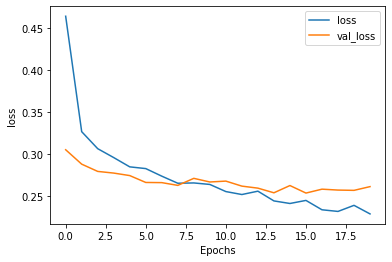

In [30]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [31]:
test_corpus=[]
for i in range(len(test_new)):
  test_corpus.append(test_new['clean_tweet'][i])

test_sequences= tokenizer.texts_to_sequences(test_corpus)
test_padded= pad_sequences(test_sequences,maxlen=max_length,padding=pad_type,truncating=trunc_type)

test_padded= np.array(test_padded)

In [49]:
predictions= (model.predict(test_padded)>0.5).astype(int)

In [50]:
file= pd.read_csv('sample_submission.csv')

In [51]:
file.head()

,id,label
0,7921,0
1,7922,0
2,7923,0
3,7924,0
4,7925,0


In [54]:
file['label']= (predictions>0.5).astype(int)

In [55]:
file.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,0
4,7925,1


In [56]:
file.to_csv('final_subm.csv',index=False,header=True)